In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab.patches import cv2_imshow

# **dataset creation**

In [ ]:
data_path= '/content/drive/MyDrive/drone_project_data/processed_data/prototype_data'

In [ ]:
data_df= pd.DataFrame([])

img_path_list= []
label_list= []

for sub_dir in iter(os.listdir(data_path)):
  sub_data_path= os.path.join(data_path, sub_dir)
  for img_path in iter(os.listdir(sub_data_path)):
    # print(img_path)
    img_path_list.append(os.path.join(sub_data_path, img_path))
    if sub_dir[9:]=='healthy':
      sub_dir_lab= 0.0
      label_list.append(sub_dir_lab)
    elif sub_dir[9:]=='Early_blight':
      sub_dir_lab= 1.0
      label_list.append(sub_dir_lab)
    elif sub_dir[9:]=='Late_blight':
      sub_dir_lab= 2.0
      label_list.append(sub_dir_lab)
    
data_df['img_path']= img_path_list
data_df['label']= label_list

In [ ]:
# data_df.to_excel('/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/img_path_list.xlsx', sheet_name= 'path_list_sheet', index= False)

In [ ]:
data_path= '/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/'
labels= []
data= pd.DataFrame([])
img_list= []
label_list= []

for item in iter(os.listdir(data_path)):
  print(item[9:])
  labels.append(item[9:])
  for img in iter(os.listdir(data_path+item)):
    # print(img)
    img_list.append(img)
    label_list.append(item[9:])

data['img_name']= img_list
data['labels']= label_list

In [ ]:
set(data['labels'])

# **PROTOTYPE PIPELINE**

*default classifier architecture*

In [ ]:
class DroneDataset(Dataset):
  def __init__(self, csv_file, transform= None):
    self.data_file= csv_file
    self.transform= transform
  
  def __len__(self):
    return len(self.data_file)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx= idx.tolist()

    image= cv2.imread(self.data_file.iloc[idx,0])
    # print(image)
    label= self.data_file.iloc[idx,1]
    # print(label)
    sample= image
    if self.transform:
      sample= self.transform(sample)
    
    return sample, label

In [ ]:
data= pd.read_excel('/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/img_path_list.xlsx')

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


img_dataset_train= DroneDataset(data[:2000], transform)
img_dataset_test= DroneDataset(data[2000:], transform)

batch_size= 128

img_data_loader_train= DataLoader(img_dataset_train, batch_size= batch_size, shuffle= True)
img_data_loader_test= DataLoader(img_dataset_test, batch_size= batch_size, shuffle= True)

In [ ]:
data

,img_path,label
0,/content/drive/MyDrive/drone_project_data/proc...,0.0
1,/content/drive/MyDrive/drone_project_data/proc...,0.0
2,/content/drive/MyDrive/drone_project_data/proc...,0.0
3,/content/drive/MyDrive/drone_project_data/proc...,0.0
4,/content/drive/MyDrive/drone_project_data/proc...,0.0
...,...,...
2147,/content/drive/MyDrive/drone_project_data/proc...,2.0
2148,/content/drive/MyDrive/drone_project_data/proc...,2.0
2149,/content/drive/MyDrive/drone_project_data/proc...,2.0
2150,/content/drive/MyDrive/drone_project_data/proc...,2.0


In [ ]:
class DroneNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(3, 6, 5)
    self.pool= nn.MaxPool2d(2,2)
    self.conv2= nn.Conv2d(6, 16, 5)
    self.fc1= nn.Linear(16*61*61, 120)
    self.fc2= nn.Linear(120, 84)
    self.fc3= nn.Linear(84, 10)
    self.fc4= nn.Linear(10, 3)

  def forward(self, x):
    x= self.pool(F.relu(self.conv1(x)))
    # print(x.shape)
    x= self.pool(F.relu(self.conv2(x)))
    # print(x.shape)
    x= torch.flatten(x, 1)
    # print(x.shape)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= F.relu(self.fc3(x))
    x= self.fc4(x)
    return x

net= DroneNet()

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(net.parameters(), lr=0.001)

In [ ]:
print("Training Classifier Model...")

for epoch in range(2):
  running_loss= 0.0
  for i, data_1 in enumerate(img_data_loader_train, 0):
    inputs, labels= data_1
    # print(labels)
    optimizer.zero_grad()

    outputs= net(inputs)
    # import pdb; pdb.set_trace();
    loss= criterion(outputs, labels)
    loss.backward()
    optimizer
    
    running_loss+= loss.item()
    # print(i, running_loss)

    if i%2 == 1:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
      running_loss = 0.0

print('Finished Training')

In [ ]:
# net(torch.tensor(cv2.imread(data['img_path'][0])))
dataiter = iter(img_data_loader_test)
images, labels = dataiter.next()
outputs= net(images)
outputs

tensor([[-0.2535, -0.1889,  0.0187],
        [-0.2578, -0.1913,  0.0226],
        [-0.2545, -0.1897,  0.0200],
        [-0.2571, -0.1912,  0.0219],
        [-0.2574, -0.1909,  0.0217],
        [-0.2579, -0.1915,  0.0233],
        [-0.2578, -0.1907,  0.0229],
        [-0.2573, -0.1905,  0.0239],
        [-0.2577, -0.1910,  0.0223],
        [-0.2561, -0.1902,  0.0214],
        [-0.2586, -0.1913,  0.0253],
        [-0.2573, -0.1905,  0.0233],
        [-0.2591, -0.1905,  0.0273],
        [-0.2590, -0.1920,  0.0244],
        [-0.2579, -0.1904,  0.0226],
        [-0.2565, -0.1905,  0.0224],
        [-0.2571, -0.1906,  0.0236],
        [-0.2597, -0.1914,  0.0258],
        [-0.2564, -0.1904,  0.0224],
        [-0.2574, -0.1898,  0.0242],
        [-0.2565, -0.1902,  0.0231],
        [-0.2563, -0.1910,  0.0207],
        [-0.2572, -0.1912,  0.0222],
        [-0.2576, -0.1914,  0.0226],
        [-0.2580, -0.1904,  0.0261],
        [-0.2580, -0.1910,  0.0233],
        [-0.2588, -0.1905,  0.0252],
 

In [ ]:
torch.max(outputs, 1)

torch.return_types.max(
values=tensor([0.0187, 0.0226, 0.0200, 0.0219, 0.0217, 0.0233, 0.0229, 0.0239, 0.0223,
        0.0214, 0.0253, 0.0233, 0.0273, 0.0244, 0.0226, 0.0224, 0.0236, 0.0258,
        0.0224, 0.0242, 0.0231, 0.0207, 0.0222, 0.0226, 0.0261, 0.0233, 0.0252,
        0.0198, 0.0217, 0.0223, 0.0215, 0.0237, 0.0221, 0.0237, 0.0233, 0.0206,
        0.0205, 0.0227, 0.0215, 0.0237, 0.0193, 0.0219, 0.0228, 0.0223, 0.0206,
        0.0228, 0.0224, 0.0243, 0.0229, 0.0221, 0.0219, 0.0230, 0.0216, 0.0228,
        0.0228, 0.0217, 0.0193, 0.0186, 0.0210, 0.0236, 0.0215, 0.0234, 0.0201,
        0.0239, 0.0223, 0.0248, 0.0217, 0.0250, 0.0236, 0.0245, 0.0234, 0.0228,
        0.0235, 0.0217, 0.0216, 0.0152, 0.0198, 0.0227, 0.0237, 0.0216, 0.0247,
        0.0236, 0.0220, 0.0223, 0.0214, 0.0258, 0.0200, 0.0221, 0.0257, 0.0215,
        0.0220, 0.0225, 0.0195, 0.0216, 0.0231, 0.0229, 0.0220, 0.0202, 0.0203,
        0.0213, 0.0237, 0.0234, 0.0257, 0.0212, 0.0233, 0.0238, 0.0255, 0.0208,
        0

In [ ]:
outputs.data.cpu().numpy().argmax()

38

In [ ]:
from torch.autograd import Variable
from PIL import Image

def predict_image(image):
    image_tensor = transform(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # input = input.to("cuda")
    output = net(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [ ]:
predict_image(Image.open(data['img_path'][2100]))

2

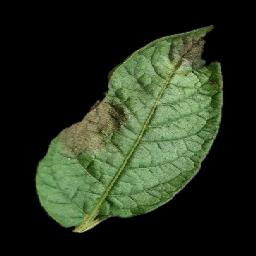

In [ ]:
Image.open(data['img_path'][2100])

In [ ]:
data['label'][2100]

2

In [ ]:
len(data[data['label']==0]), len(data[data['label']==1]), len(data[data['label']==2])

(152, 1000, 1000)

*unet architecture*

In [ ]:
class DroneDataset(Dataset):
  def __init__(self, csv_file, transform= None):
    self.data_file= csv_file
    self.transform= transform
  
  def __len__(self):
    return len(self.data_file)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx= idx.tolist()

    image= cv2.imread(self.data_file.iloc[idx,0])
    # print(image)
    label= torch.tensor(self.data_file.iloc[idx,1])
    # if label==0:
    #   label= 0.0
    # else:
    #   label==1.0
    # print(label)
    sample= image
    if self.transform:
      sample= self.transform(sample)
    
    return sample, label

In [ ]:
data= pd.read_excel('/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/img_path_list.xlsx')

transform = transforms.Compose(
    [transforms.ToTensor(),])
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_dataset_train= DroneDataset(data[:2000], transform)
img_dataset_test= DroneDataset(data[2000:], transform)

batch_size= 8

img_data_loader_train= DataLoader(img_dataset_train, batch_size= batch_size, shuffle= True)
img_data_loader_test= DataLoader(img_dataset_test, batch_size= batch_size, shuffle= True)

In [ ]:
# iter(img_data_loader_train).next()[0].shape

In [ ]:
#unet model encoder-decoder architecture

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, mid_channels= None):
    super().__init__()
    if not mid_channels:
      mid_channels= out_channels
    
    self.double_conv= nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size= 3, padding= 1, bias= False),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(),
        nn.Conv2d(mid_channels, out_channels, kernel_size= 3, padding= 1, bias= False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
  
  def forward(self, x):
    return self.double_conv(x)


class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.maxpool_conv= nn.Sequential(
        nn.MaxPool2d(2),
        DoubleConv(in_channels, out_channels)
    )
  
  def forward(self, x):
    return self.maxpool_conv(x)


class Up(nn.Module):
  def __init__(self, in_channels, out_channels, bilinear= True):
    super().__init__()
    if bilinear:
      self.up= nn.Upsample(scale_factor= 2, mode= 'bilinear', align_corners= True)
      self.conv= DoubleConv(in_channels, out_channels, in_channels//2)
    else:
      self.up= nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size= 2, stride= 2)
      self.conv= DoubleConv(in_channels, out_channels)
  
  def forward(self, x1, x2):
    x1= self.up(x1)
    diffY= x2.size()[2]- x1.size()[2]
    diffX= x2.size()[3]- x1.size()[3]
    x1= F.pad(x1, [diffX//2, diffX-diffX//2,
                   diffY//2, diffY-diffY//2])
    x= torch.cat([x2, x1], dim= 1)
    return self.conv(x)


class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv= nn.Conv2d(in_channels, out_channels, kernel_size= 1)
  
  def forward(self, x):
    return self.conv(x)

In [ ]:
#full architecture of UNet model

class UNet(nn.Module):
  def __init__(self, n_channels, n_classes, bilinear= False):
    super(UNet, self).__init__()
    self.n_channels= n_channels
    self.n_classes= n_classes
    self.bilinear= bilinear

    self.inc= DoubleConv(n_channels, 64)
    self.down1= Down(64, 128)
    self.down2= Down(128, 256)
    self.down3= Down(256, 512)
    factor= 2 if bilinear else 1
    self.down4= Down(512, 1024//factor)
    self.up1= Up(1024, 512//factor, bilinear)
    self.up2= Up(512, 256//factor, bilinear)
    self.up3= Up(256, 128//factor, bilinear)
    self.up4= Up(128, 64, bilinear)
    self.outc= OutConv(64, n_classes)
  
  def forward(self, x):
    x1= self.inc(x)
    x2= self.down1(x1)
    x3= self.down2(x2)
    x4= self.down3(x3)
    x5= self.down4(x4)
    x= self.up1(x5, x4)
    x= self.up2(x, x3)
    x= self.up3(x, x2)
    x= self.up4(x, x1)
    logits= self.outc(x)
    return logits


net= UNet(3, 3)

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(net.parameters(), lr=0.001)

In [ ]:
print("Training UNet Model...")

for epoch in range(2):
  running_loss= 0.0
  for i, data_1 in enumerate(img_data_loader_train, 0):
    inputs, labels= data_1
    # print(labels)
    optimizer.zero_grad()
    # import pdb; pdb.set_trace();
    outputs= net(inputs)
    import pdb; pdb.set_trace();
    loss= criterion(outputs, labels)
    loss.backward()
    optimizer
    
    running_loss+= loss.item()
    # print(i, running_loss)

    if i%2 == 1:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
      running_loss = 0.0

print('Finished Training')

In [ ]:
iter(img_data_loader_train).next()[0].detach().numpy().shape

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# from utils.data_loading import BasicDataset, CarvanaDataset
# from utils.dice_score import dice_loss
# from evaluate import evaluate
# from unet import UNet

dir_img = ''
dir_mask = ''
dir_checkpoint = ''


# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(net.parameters(), lr=1e-5, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss()
global_step = 0

# 5. Begin training
for epoch in range(1, 3):
    net.train()
    epoch_loss = 0
    with tqdm(total=2000, desc=f'Epoch {epoch}/3', unit='img') as pbar:
        for batch in img_data_loader_train:
            # images = batch['image']
            # true_masks = batch['mask']

            images, true_masks= batch

            assert images.shape[1] == net.n_channels, \
                f'Network has been defined with {net.n_channels} input channels, ' \
                f'but loaded images have {images.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'

            images = images.to(device='cpu', dtype=torch.float32)
            true_masks = true_masks.to(device='cpu', dtype=torch.long)

            with torch.cuda.amp.autocast(enabled=False):
                masks_pred = net(images)
                loss = criterion(masks_pred, true_masks)

            optimizer.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            pbar.update(images.shape[0])
            global_step += 1
            epoch_loss += loss.item()


*scratch architecture*

In [ ]:
class DroneDataset(Dataset):
  def __init__(self, csv_file, transform= None):
    self.data_file= csv_file
    self.transform= transform
  
  def __len__(self):
    return len(self.data_file)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx= idx.tolist()

    image= cv2.imread(self.data_file.iloc[idx,0])
    label= self.data_file.iloc[idx,1]
    sample= image
    if self.transform:
      sample= self.transform(sample)
    
    return sample, label

In [ ]:
data= pd.read_excel('/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/img_path_list.xlsx')

transform = transforms.Compose(
    [transforms.ToTensor(),])
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

img_dataset_train= DroneDataset(data[:2000], transform)
img_dataset_test= DroneDataset(data[2000:], transform)

batch_size= 128

img_data_loader_train= DataLoader(img_dataset_train, batch_size= batch_size, shuffle= True)
img_data_loader_test= DataLoader(img_dataset_test, batch_size= batch_size, shuffle= True)

In [ ]:
class DroneNetArchitecure(nn.Module):
  def __init__(self):
    super(DroneNetArchitecure, self).__init__()
    self.conv1= nn.Conv2d(3,8, 3, padding= 1)
    self.conv2= nn.Conv2d(8,16, 3, padding= 1)
    self.conv3= nn.Conv2d(16,32, 3, padding= 1)
    self.conv4= nn.Conv2d(32,64, 3, padding= 1)
    self.conv5= nn.Conv2d(64,128, 3, padding= 1)
    self.conv6= nn.Conv2d(128,256, 3, padding= 1)
    self.conv7= nn.Conv2d(256,512, 3, padding= 1)
    self.pool= nn.MaxPool2d(2)
    self.fc1= nn.Linear(512*2*2, 1500)
    self.fc2= nn.Linear(1500, 1100)
    self.fc3= nn.Linear(1100, 800)
    self.fc4= nn.Linear(800, 300)
    self.fc5= nn.Linear(300, 84)
    self.fc6= nn.Linear(84, 30)
    self.fc7= nn.Linear(30, 3)
    self.dp= nn.Dropout(0.5)
  
  def forward(self, x):
    x= self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    x= self.pool(F.relu(self.conv3(x)))
    x= self.pool(F.relu(self.conv4(x)))
    x= self.pool(F.relu(self.conv5(x)))
    x= self.pool(F.relu(self.conv6(x)))
    x= self.pool(F.relu(self.conv7(x))) 
    # import pdb; pdb.set_trace();
    x= torch.flatten(x, 1)
    # import pdb; pdb.set_trace();
    x= F.relu(self.dp(self.fc1(x)))
    x= F.relu(self.dp(self.fc2(x)))
    x= F.relu(self.dp(self.fc3(x)))
    x= F.relu(self.dp(self.fc4(x)))
    x= F.relu(self.dp(self.fc5(x)))
    x= F.relu(self.dp(self.fc6(x)))
    x= self.fc7(x)

    return x

net= DroneNetArchitecure()

In [ ]:
class CNN(nn.Module):
    """Convolutional Neural Network which does the raining."""

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(32 * 62 * 62, 1024)
        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # import pdb; pdb.set_trace();
        x = x.view(-1, 32 * 62 * 62)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

net= CNN()

In [ ]:
class BasicCNN(nn.Module):
    """Convolutional Neural Network which does the raining."""

    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3)
        # self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3 * 252 * 252, 1024)
        self.fc2 = nn.Linear(1024, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # import pdb; pdb.set_trace();
        # x = x.view(-1, 32 * 62 * 62)
        x = F.relu(self.fc1(x))
        # x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

net= BasicCNN()

In [ ]:
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(net.parameters(), lr=0.01)

In [ ]:
device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
net.to('cuda'), device

(DroneNetArchitecure(
   (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (fc1): Linear(in_features=2048, out_features=1500, bias=True)
   (fc2): Linear(in_features=1500, out_features=1100, bias=True)
   (fc3): Linear(in_features=1100, out_features=800, bias=True)
   (fc4): Linear(in_features=800, out_features=300, bias=True)
   (fc5): Linear(in_features=300, out_features=84, bias=True)
   (fc6): Linear(in_featu

In [ ]:
print("Training DroneNet Model...")

running_loss_arr= []
for epoch in range(30):
  running_loss= 0.0
  count= 0
  for i, data_1 in enumerate(img_data_loader_train, 0):
    inputs, labels= data_1
    # print(labels)
    optimizer.zero_grad()
    # inputs.is_cuda
    # import pdb; pdb.set_trace();
    outputs= net(inputs.to(device))
    labels = labels.long().to(device)
    # labels.is_cuda
    # import pdb; pdb.set_trace();
    loss= criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    running_loss+= loss.item()
    count+= running_loss
    
    # print(i, running_loss)

    if i%2 == 1:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
      running_loss = 0.0
  running_loss_arr.append(count)

print('Finished Training')

Training DroneNet Model...
[1,     2] loss: 33.097
[1,     4] loss: 0.011
[1,     6] loss: 0.011
[1,     8] loss: 0.013
[1,    10] loss: 0.011
[1,    12] loss: 0.011
[1,    14] loss: 0.011
[1,    16] loss: 0.010
[2,     2] loss: 0.011
[2,     4] loss: 0.010
[2,     6] loss: 0.010
[2,     8] loss: 0.010
[2,    10] loss: 0.010
[2,    12] loss: 0.010
[2,    14] loss: 0.010
[2,    16] loss: 0.010
[3,     2] loss: 0.010
[3,     4] loss: 0.010
[3,     6] loss: 0.010
[3,     8] loss: 0.010
[3,    10] loss: 0.009
[3,    12] loss: 0.009
[3,    14] loss: 0.009
[3,    16] loss: 0.010
[4,     2] loss: 0.009
[4,     4] loss: 0.009
[4,     6] loss: 0.010
[4,     8] loss: 0.009
[4,    10] loss: 0.009
[4,    12] loss: 0.009
[4,    14] loss: 0.009
[4,    16] loss: 0.009
[5,     2] loss: 0.009
[5,     4] loss: 0.010
[5,     6] loss: 0.009
[5,     8] loss: 0.010
[5,    10] loss: 0.009
[5,    12] loss: 0.009
[5,    14] loss: 0.009
[5,    16] loss: 0.009


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)

plt.plot(list(range(0,20)), running_loss_arr, linewidth=3, marker='o')

plt.xlabel("no of epochs",fontsize=20)

plt.ylabel("loss", fontsize=20)

plt.title('Loss curve', fontsize=20)

# plt.savefig('/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/loss_curve_10epo.jpg')

*resnet9*

In [ ]:
def conv_block(in_channels, out_channels, pool=False,p_size=2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(p_size))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(3, 32)                             #32x150x150
        self.conv2 = conv_block(32, 64, pool=True,p_size=4)                  #64x37x37
        self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64))
        
        self.conv3 = conv_block(64, 128, pool=True,p_size=4)                 #128x9x9
        self.conv4 = conv_block(128, 256, pool=True,p_size=4)                #256x2x2
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),                     #256x1x1
                                        nn.Flatten(), 
                                        nn.Linear(256, 3))
        
    def forward(self, xb):
        
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        
        out = self.classifier(out)
        
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= ResNet9(3,3).to(device)

In [ ]:
print("Training ResNet9 Model...")

running_loss_arr= []
for epoch in range(2):
  running_loss= 0.0
  count= 0
  for i, data_1 in enumerate(img_data_loader_train, 0):
    inputs, labels= data_1
    # print(labels)
    optimizer.zero_grad()
    # inputs.is_cuda
    # import pdb; pdb.set_trace();
    outputs= net(inputs.to(device))
    labels = labels.long().to(device)
    # labels.is_cuda
    # import pdb; pdb.set_trace();
    loss= criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    running_loss+= loss.item()
    count+= running_loss
    
    # print(i, running_loss)

    if i%2 == 1:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
      running_loss = 0.0
  running_loss_arr.append(count)

print('Finished Training')

*resnet architecture implementation*

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = '/content/drive/MyDrive/drone_project_data/processed_data/prototype_data/Potato___healthy/5ea316eb-10a2-42c0-b781-40d90356ccaa___RS_HL 1935_final_masked.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
Predicted: [('n12768682', 'buckeye', 0.36075467), ('n03991062', 'pot', 0.13052243), ('n02259212', 'leafhopper', 0.07982557)]
